In [1]:
import numpy as np
import hera_cal.redcal as rc
import matplotlib.pyplot as plt
import scipy.cluster
from scipy import constants, signal
import scipy
import linsolve

%matplotlib notebook 

In [104]:
hexnum = 11
splitCore = True
splitCoreOutriggers = 4
min_ubl_per_orient = 2
min_perfect_overlap = 14
#freqs = np.linspace(.1,.2,1024, endpoint=False) # in GHz
freqs = np.linspace(.05,.25,2048, endpoint=False) # in GHz
chans = {chan: freq for chan,freq in enumerate(freqs)}
#TODO: replace this with freqs = 

# Build Array

In [105]:
def build_hex_array(hexNum, sep=14.7):
    antpos, i = {}, 0
    for row in range(hexNum-1,-(hexNum),-1):
        for col in range(2*hexNum-abs(row)-1):
            xPos = ((-(2*hexNum-abs(row))+2)/2.0 + col)*sep;
            yPos = row*sep*3**.5/2;
            antpos[i] = np.array([xPos, yPos, 0])
            i += 1
    return antpos

In [106]:
def build_split_core_hex_array(hexNum, splitCore=True, splitCoreOutriggers=0, sep=14.7):

    #Main Hex
    positions = [];
    for row in range(hexNum-1,-(hexNum)+splitCore,-1):
        for col in range(0,2*hexNum-abs(row)-1):
            xPos = ((-(2*hexNum-abs(row))+2)/2.0 + col)*sep;
            yPos = row*sep*3**.5/2;
            positions.append(np.array([xPos, yPos, 0]))

    right = sep*np.asarray([1,0,0])
    up = sep*np.asarray([0,1,0])
    upRight = sep*np.asarray([.5,3**.5/2,0])
    upLeft = sep*np.asarray([-.5,3**.5/2,0])

    #Split the core into 3 pieces
    if splitCore:
        newPos = []
        for i,pos in enumerate(positions):          
            theta = np.arctan2(pos[1],pos[0])
            if (pos[0]==0 and pos[1]==0):
                newPos.append(pos)
            elif (theta > -np.pi/3 and theta < np.pi/3):
                newPos.append(np.asarray(pos) + (upRight + upLeft)/3)                    
            elif (theta >= np.pi/3 and theta < np.pi):
                newPos.append(np.asarray(pos) +upLeft  - (upRight + upLeft)/3)
            else:
                newPos.append(pos)
        positions = newPos

    nCore = len(positions)

    if splitCoreOutriggers > 0:
        exteriorHexNum = splitCoreOutriggers
        for row in range(exteriorHexNum-1,-(exteriorHexNum),-1):
            for col in range(2*exteriorHexNum-abs(row)-1):
                xPos = ((-(2*exteriorHexNum-abs(row))+2)/2.0 + col)*sep*(hexNum-1)
                yPos = row*sep*(hexNum-1)*3**.5/2
                theta = np.arctan2(yPos,xPos)       
                if ((xPos**2 + yPos**2)**.5 > sep*(hexNum+1)):
                    if (theta > 0 and theta <= 2*np.pi/3+.01):
                        positions.append(np.asarray([xPos, yPos, 0]) - 4*(upRight + upLeft)/3)
                    elif (theta <= 0 and theta > -2*np.pi/3):
                        positions.append(np.asarray([xPos, yPos, 0])- 2*(upRight + upLeft)/3)
                    else:
                        positions.append(np.asarray([xPos, yPos, 0]) - 3*(upRight + upLeft)/3)

    return {i: pos for i,pos in enumerate(positions)}

# Get Orientations

In [107]:
def Get_Unique_Orientations(pos, pos_reds, min_ubl_per_orient=1):
    """TODO: Document"""
    ubl_pairs = [red[0] for red in pos_reds]
    ubl_pairs = [bl for length,bl in sorted(zip([np.linalg.norm(pos[i] - pos[j]) for (i,j) in ubl_pairs], ubl_pairs))]
    ors = [(pos[i] - pos[j])/np.linalg.norm(pos[i] - pos[j]) for (i,j) in ubl_pairs]

    clusters = scipy.cluster.hierarchy.fclusterdata(ors,1e-10, criterion='distance')
    uors = [[] for i in range(np.max(clusters))]
    for cluster, bl in zip(clusters,ubl_pairs):
        uors[cluster-1].append(bl)
    uors = [uor for uor in uors if len(uor) > min_ubl_per_orient]
    return uors

pos = build_hex_array(hexnum)
pos = build_split_core_hex_array(hexnum, splitCore=splitCore, splitCoreOutriggers=splitCoreOutriggers, sep=14.7)
pos_reds = rc.get_pos_reds(pos)
uors = Get_Unique_Orientations(pos, pos_reds, min_ubl_per_orient = min_ubl_per_orient)
redundancy = {red[0]: len(red) for red in pos_reds}

376 unique orientations are being used.


<IPython.core.display.Javascript object>


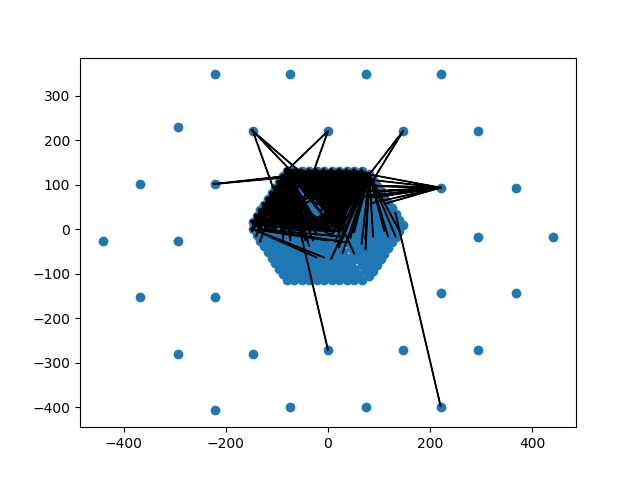

In [108]:
print len(uors), 'unique orientations are being used.'
plt.figure()
plt.scatter(np.array(pos.values())[:,0], np.array(pos.values())[:,1])
ax = plt.axes()
for uor in uors:
    i,j = uor[0]
    ax.arrow(pos[i][0],pos[i][1], pos[j][0]-pos[i][0], pos[j][1]-pos[i][1], width=1)
for ubl in uors[0]:
    i,j = ubl
    ax.arrow(pos[i][0],pos[i][1], pos[j][0]-pos[i][0], pos[j][1]-pos[i][1], width=1)


# Find perfect overlaps

In [109]:
class Overlap():
    
    def __init__(self, bls, chans, uor_exemplar, u_int):
        '''todo: document'''
        self.bls = bls
        self.chans = chans
        self.uor_exemplar = uor_exemplar
        self.uint = u_int
        
    def figure_out_u(self, pos, chans):
        bl0 = pos[self.bls[0][0]] - pos[self.bls[0][1]]
        freq0 = chans[self.chans[0]]
        self.u_vec = bl0 * freq0 * 1e9 / constants.c
        self.u = np.linalg.norm(self.u_vec)

def find_overlaps_in_orientation(uor, pos, chans, min_perfect_overlap):
    '''TODO: document'''
    freqs = sorted(chans.values())
    df = np.median(np.diff(freqs))
    freq_ints = np.array(np.round(freqs/df), dtype=int)
    freq_to_chan = {freq: chan for chan,freq in chans.items()}
    freq_int_to_chan = {freq_int: freq_to_chan[freq] for freq,freq_int in zip(freqs,freq_ints)}
    
    ubl_lengths = np.array([np.linalg.norm(pos[i]-pos[j]) for i,j in uor])
    dbl = ubl_lengths[0] / 2 
    # Hardcoded for HERA, in which all baselines are (half-)integer mutiples of the shortest baseline in an orientation
    ubl_len_ints = np.array(np.round(ubl_lengths/dbl), dtype=int)
    
    u_ints = np.outer(ubl_len_ints, freq_ints).flatten()
    unique, counts = np.unique(u_ints, return_counts=True)
    
    overlaps = {}
    for u_int in sorted(unique[counts>=min_perfect_overlap]):
        overlap_bls, overlap_chans = [], []
        for ubl, ubl_len_int in zip(uor, ubl_len_ints):        
            if u_int % ubl_len_int == 0 and u_int/ubl_len_int in freq_ints:
                overlap_bls.append(ubl)
                overlap_chans.append(freq_int_to_chan[u_int/ubl_len_int])
        overlaps[(overlap_bls[0], overlap_chans[0])] = Overlap(overlap_bls, overlap_chans, uor[0], u_int)
        overlaps[(overlap_bls[0], overlap_chans[0])].figure_out_u(pos, chans)
    return overlaps

In [110]:
overlaps = {}
for uor_index, uor in enumerate(uors):
    overlaps.update(find_overlaps_in_orientation(uor, pos, chans, min_perfect_overlap))

Let's think about data structures for a minute. What information do we really want to retain?

Ultimately, the equation we're thinking about will be $V(u,v,\nu) \approx \beta(\nu) \Sigma(u,v,\nu)$ where $\beta$ is a (potentially high) order polynomial or Fourier component and $\Sigma$ is a low order polynomial in $\log(\nu)$. 

For the purposes of simulation, we want to pick out all the baselines involved, then pick out all channels involved in each...I think that's the simplest way because it allows for vectorization.

# Diagnostic Statistics on Overlaps

<IPython.core.display.Javascript object>


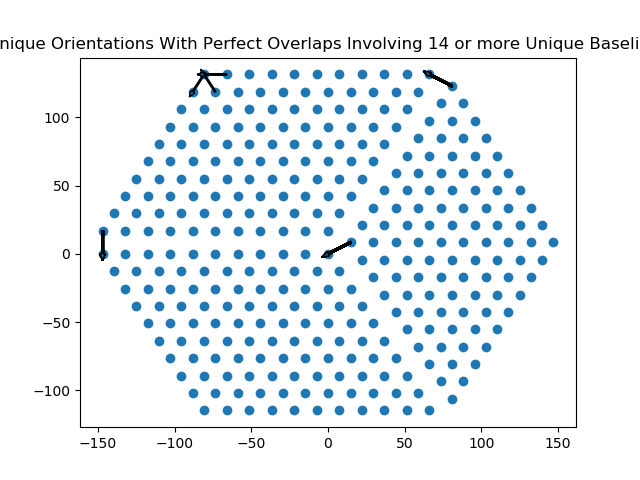

In [111]:
plt.figure()
plt.scatter(np.array(pos.values())[:320,0], np.array(pos.values())[:320,1])
ax = plt.axes()
plt.title('Unique Orientations With Perfect Overlaps Involving ' + str(min_perfect_overlap) + ' or more Unique Baselines' )        

for ovlp in overlaps.values():
    i,j = ovlp.uor_exemplar
    ax.arrow(pos[i][0],pos[i][1], pos[j][0]-pos[i][0], pos[j][1]-pos[i][1], width=1)

In [10]:
chans_involved = set([chan for overlap in overlaps.values() for chan in overlap.chans])
ubl_involved = set([ubl for overlap in overlaps.values() for ubl in overlap.bls])
n_pairs_involved = np.sum([len(overlap.bls) for overlap in overlaps.values()])
n_bl_involved = np.sum([redundancy[ubl] for overlap in overlaps.values() for ubl in overlap.bls])

print 'number of unique us:', len(overlaps)
print 'number of ubl involved:', len(ubl_involved), '(' + str(np.round(100.0 * len(ubl_involved)/len(np.array(pos_reds).flatten()),3)) + '%)'
print 'number of chans involved:', len(chans_involved), '(' + str(np.round(100.0 * len(chans_involved)/len(chans),3)) + '%)'
print 'number of ubl-chans involved: ', n_pairs_involved
print 'number of bl-chan involved:', n_bl_involved, '(' + str(np.round(100.0 * n_bl_involved / (len(pos)*(len(pos)-1)/2.0) / len(chans),3)) + '%)'

number of unique us: 61
number of ubl involved: 119 (1.8%)
number of chans involved: 153 (7.471%)
number of ubl-chans involved:  1021
number of bl-chan involved: 16987 (0.014%)


In [112]:
all_chans = [chan for overlap in overlaps.values() for chan in overlap.chans]
unique, counts = np.unique(all_chans, return_counts=True)

<IPython.core.display.Javascript object>


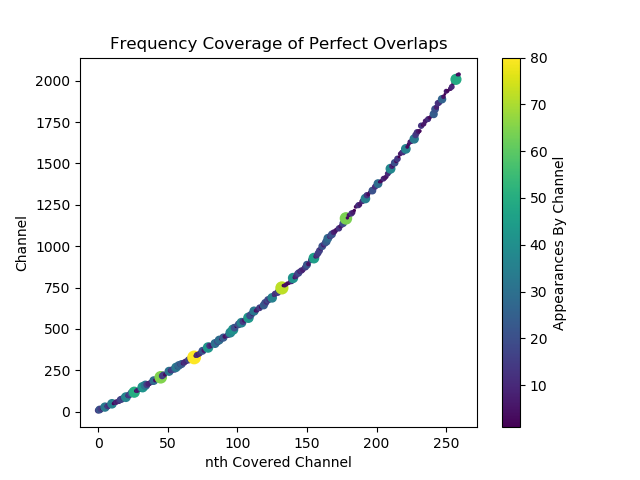

In [113]:
plt.figure()
plt.scatter(range(len(unique)), unique, c=counts, s=counts)
plt.title('Frequency Coverage of Perfect Overlaps')
plt.xlabel('nth Covered Channel')
plt.ylabel('Channel')
plt.colorbar(label='Appearances By Channel')

<IPython.core.display.Javascript object>


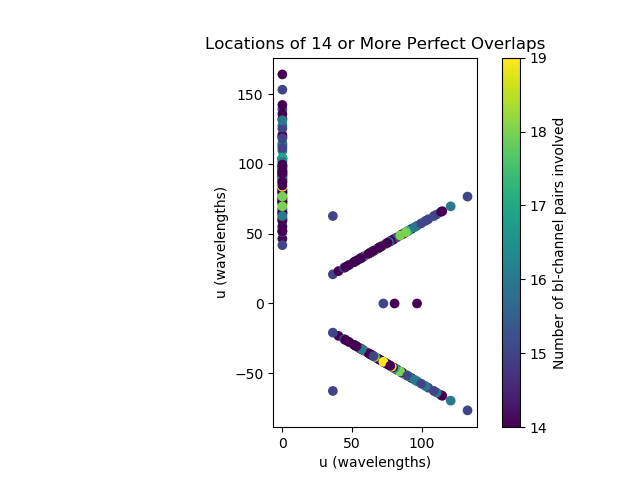

Text(0.5,1,u'Locations of 14 or More Perfect Overlaps')

In [114]:
plt.figure()
uvecs = np.array([overlap.u_vec for overlap in overlaps.values()])
n_overlapping = np.array([len(overlap.chans) for overlap in overlaps.values()])
plt.scatter(uvecs[:,0],uvecs[:,1], c = n_overlapping)
plt.axes().set_aspect('equal')
plt.xlabel('u (wavelengths)')
plt.ylabel('u (wavelengths)')
plt.colorbar(label='Number of bl-channel pairs involved')
plt.title('Locations of ' + str(min_perfect_overlap) + ' or More Perfect Overlaps')

# Build Simulation

In [115]:
class SourceCatalog():
    def __init__(self):
        self.ras, self.decs, self.refFluxes, self.refFreqs, self.alphas = (np.array([]) for i in range(5))
        self.LST = 0.0
    
    def addSource(self, ra, dec, refFlux, refFreq, alpha):
        """Used for manually adding a power-law source by hand."""
        self.ras = np.append(self.ras,ra)
        self.decs = np.append(self.decs,dec)
        self.refFluxes = np.append(self.refFluxes,refFlux)
        self.refFreqs = np.append(self.refFreqs,refFreq)
        self.alphas = np.append(self.alphas,alpha)

    def update_horizontal_coords(self, LST, arrayLatInRad = -0.53619181096511):
        """ Convert RAs and Decs in radians to altitudes and azimuths in radians, given an LST and array location in the specs object """
        self.LST = LST
        RAs = self.ras*np.pi/180. #convert to radians
        decs = self.decs*np.pi/180.
        lha = np.pi/12.0*self.LST - RAs #local hour angle
        self.alts = np.arcsin(np.sin(arrayLatInRad) * np.sin(decs) + np.cos(arrayLatInRad) * np.cos(decs) * np.cos(lha))
        self.azs = np.arctan2( np.sin(lha) * np.cos(decs), np.cos(lha) * np.cos(decs) * np.sin(arrayLatInRad) - np.sin(decs) * np.cos(arrayLatInRad)) + np.pi
        self.carts = np.array([np.sin(self.azs)*np.cos(self.alts), np.cos(self.azs)*np.cos(self.alts), np.sin(self.alts)])
    
    def visibilities(self, baseline, freqs, beamSize = 30.0):
        """baseline = np.array([dx,dy,dz]), freqs = list in GHz"""
        #sigmas = beamSize*2.*np.pi/360./2.355 *(freqs/.150)**-1.
        sigmas = beamSize*2.*np.pi/360./2.355 *(freqs/.150)**0
        # NOTE: For now, I'm using a frequency-independent beam
        fluxes = np.array([self.refFluxes * (freq/self.refFreqs)**(-self.alphas) for freq in freqs])
        
        
        #TODO: fix this mess!!!
        zComp = np.sin(self.alts)
        xsqysq = 1 - zComp**2
        
        beams = np.array([(self.alts > 0) * np.exp(-(np.cos(self.alts))**2./(2.*sigma**2)) for sigma in sigmas])
        beams = np.ones_like(beams)
        exponents = np.array([np.exp(-2.0j*np.pi/(constants.c/(freq*1e9))*baseline.dot(self.carts)) for freq in freqs])
        visibility = np.sum(fluxes * beams * exponents, axis=1)
        return visibility

In [116]:
sc = SourceCatalog()
sc.addSource(10,-30,10,.15,.5)
sc.addSource(0,-35,20,.15,.6)
sc.addSource(20,-25,15,.15,.4)
sc.addSource(40,-5,45,.15,.3)
sc.addSource(5,-30,14,.15,.4)
sc.update_horizontal_coords(LST = 0)

#TODO: update with powerlaw fit to beam-weighted-sky average
sky_power_law = {chan: (freq/.15)**(-np.average(sc.alphas, weights=sc.refFluxes)) for chan, freq in chans.items()}

In [117]:
chans_needed = {}
for overlap in overlaps.values():
    for bl, chan in zip(overlap.bls,overlap.chans):
        if chans_needed.has_key(bl):
            chans_needed[bl].append(chan)
        else:
            chans_needed[bl] = [chan]

for bl in chans_needed.keys():
    chans_needed[bl] = sorted(chans_needed[bl])

In [118]:
data = {}
for bl, needed in chans_needed.items():
    bl_vec = pos[bl[0]] - pos[bl[1]]
    freqs_needed = np.array([chans[chan] for chan in needed])
    vis = sc.visibilities(bl_vec, freqs_needed, beamSize = 10.0)
    data[bl] = {chan: v for chan,v in zip(needed,vis)}
    
mean_abs_vis = np.mean([np.abs(data[bl][chan]) for bl in data.keys() for chan in data[bl].keys()])

# Apply Bandpass

In [119]:
bandpass = {chan: 1.0 + .1*np.exp(1.0j * freq * 200) for chan,freq in chans.items()}
data_rescaled = {bl: {chan: data[bl][chan] / mean_abs_vis / sky_power_law[chan] for chan in data[bl].keys()} for bl in data.keys()} 
data_with_bp = {bl: {chan: bandpass[chan] * data_rescaled[bl][chan] for chan in data_rescaled[bl].keys()} for bl in data_rescaled.keys()}


<IPython.core.display.Javascript object>


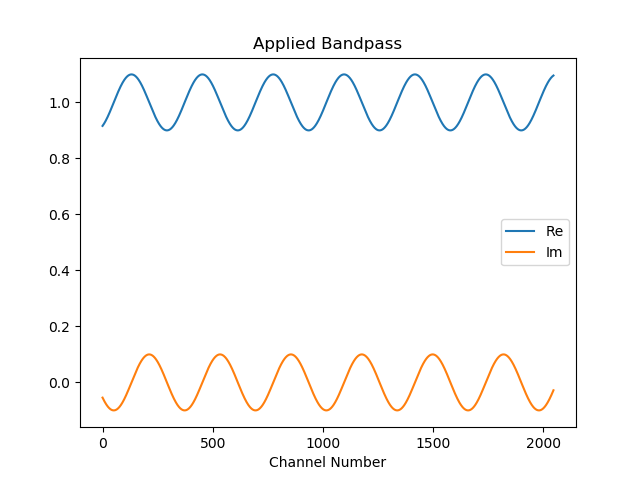

In [120]:
plt.figure()
plt.title('Applied Bandpass')
plt.plot(bandpass.keys(), np.real(bandpass.values()), label='Re')
plt.plot(bandpass.keys(), np.imag(bandpass.values()), label='Im')
plt.legend()
plt.xlabel('Channel Number');

In [ ]:
test = overlaps.values()[2]
plt.figure()
freqs = [chans[chan] for chan in test.chans]
vis = [data_with_bp[bl][chan] for chan,bl in zip(test.chans, test.bls)]
plt.plot(np.imag(vis),freqs,'.-')

# uCalibrator

In [141]:
class uCalibrator():
    
    def __init__(self, overlaps, chans, bp_model='channels', u_model='polylogf', solver_fcn = linsolve.LinProductSolver, **kwargs):
        '''TODO: Document'''
        self.overlaps, self.chans = overlaps, chans
        self.bp_model, self.u_model, self.solver_fcn = bp_model, u_model, solver_fcn
        if u_model == 'polylogf':
            #if u_order is not set in kwargs and model is a polynomial in log frequency, default is 5
            self.u_order = kwargs.get('u_order', 5)
#         if bp_model == 'fourier':
#             self.bp_terms = kwargs.get('bp_terms', 7)
#             assert(bp_terms % 2 == 1)
#             self.fourier_constants()


#     def fourier_constants(self):
#         self.B = np.max(self.chans.values())-np.min(self.chans.values())
#         self.f0 = np.mean(self.chans.values())
#         self.consts = {}
#         self.sol0 = {}
#         for chan, f in self.chans.items():
#             for n in range(self.bp_terms):
#                 exponential = np.exp(2.0j * np.pi * (f-self.f0)/self.B * (n - (self.bp_terms-1)/2))
#                 self.consts['exp_c%d_n%d' % (chan,n)] = exponential
    
#    def bandpass_terms(self, )
    

    def bp_terms(self, chan):
        '''For a given channel, return a list of terms that describe the bandpass model.'''
        if self.bp_model == 'channels':
            bp_terms = ['bp_%d' % chan]
        elif self.bp_model == 'ones':
            bp_terms = ['1.0']
        else:
            raise NotImplementedError, 'Only bp_models "channels" and "ones" have been implemented.'
        return bp_terms     
    
    def bandpass(self, sol):
        if self.bp_model == 'channels':
            bandpass = {chan: sol['bp_%d'% chan] for chan in self.chans.keys() if sol.has_key('bp_%d'% chan)}
        elif self.bp_model == 'ones':
            bandpass = {chan: 1.0 for chan in self.chans.keys()}
        else:
            raise NotImplementedError, 'Only bp_models "channels" and "ones" have been implemented.'
        return bandpass    
        
    def overlap_to_prefix(self, overlap):
        '''Converts a particular overlap in u into a unique string formatted as:
        u_[uint]_b_[bl0[0]]_[bl0[1]] where bl0 is the 0th baseline in overlap.bls'''
        return 'u_%d_b_%d_%d' % (overlap.uint, overlap.bls[0][0], overlap.bls[0][1])
    
    def u_terms(self, overlap, chan):
        '''For a given overlap and channel, return a list of terms that describe the sky model for that value of u.'''        
        if self.u_model == 'polylogf':
            u_prefix = self.overlap_to_prefix(overlap)
            u_terms =  [u_prefix + '_logf_%d*%f' % (o, np.log10(self.chans[chan])**o) for o in range(self.u_order+1)]
        else:
            raise NotImplementedError, 'Only u_model "polylogf" has been implemented.'
        return u_terms

    def build_eqs(self, data):
        '''For for all bl/channel pairs, build up a dictionary that generates equations as dictionary entries.'''
        eqs = {}
        for key,overlap in self.overlaps.items():
            for bl,chan in zip(overlap.bls, overlap.chans):
                if data.has_key(bl) and data[bl].has_key(chan):
                    bpt = self.bp_terms(chan)
                    ut = self.u_terms(overlap, chan)
                    eqs[' + '.join([b + '*' + u for b in bpt for u in ut])] = (bl,chan)
        return eqs

    
    def get_all_vars(self, data):
        '''TODO: document'''
        import ast
        all_terms = [linsolve.ast_getterms(ast.parse(k, mode='eval')) for k in self.build_eqs(data)]
        all_vars = set([t for terms in all_terms for term in terms for t in term if type(t) == str])
        return list(all_vars)
    
    def build_d_and_w(self, data, wgts={}):
        """TODO: document"""
        eqs = self.build_eqs(data)
        d, w = {}, {}
        for eq,(bl,chan) in eqs.items():
            d[eq] = data[bl][chan]
            w[eq] = wgts.get(bl,{}).get(chan, 1.0) #if bl/chan not in weights, weight is 1.0
        return d, w
    
    def solver(self, data, wgts={}, sparse=False, **kwargs):
        """TODO: document. TODO: add weights"""
        d, w = self.build_d_and_w(data, wgts=wgts)
        return self.solver_fcn(d, wgts=w, sparse=sparse, **kwargs)

    


    
uc0 = uCalibrator(overlaps, chans, bp_model='ones', u_model='polylogf', u_order=0, solver_fcn=linsolve.LinearSolver) 
ls = uc0.solver(data_with_bp)
sol0 = ls.solve()

for o in range(4):
    print 'Now working on order', o, '...'
    uc = uCalibrator(overlaps, chans, bp_model='channels', u_model='polylogf', u_order=o)
    all_vars = uc.get_all_vars(data_with_bp)
    sol0 = {var: sol0.get(var, 1.0) if 'bp' in var else sol0.get(var, 0.0) for var in all_vars}
    lps = uc.solver(data_with_bp, sol0=sol0)
    meta, sol1 = lps.solve_iteratively(maxiter=200)

Now working on order 0 ...
Now working on order 1 ...
Now working on order 2 ...
Now working on order 3 ...


<IPython.core.display.Javascript object>


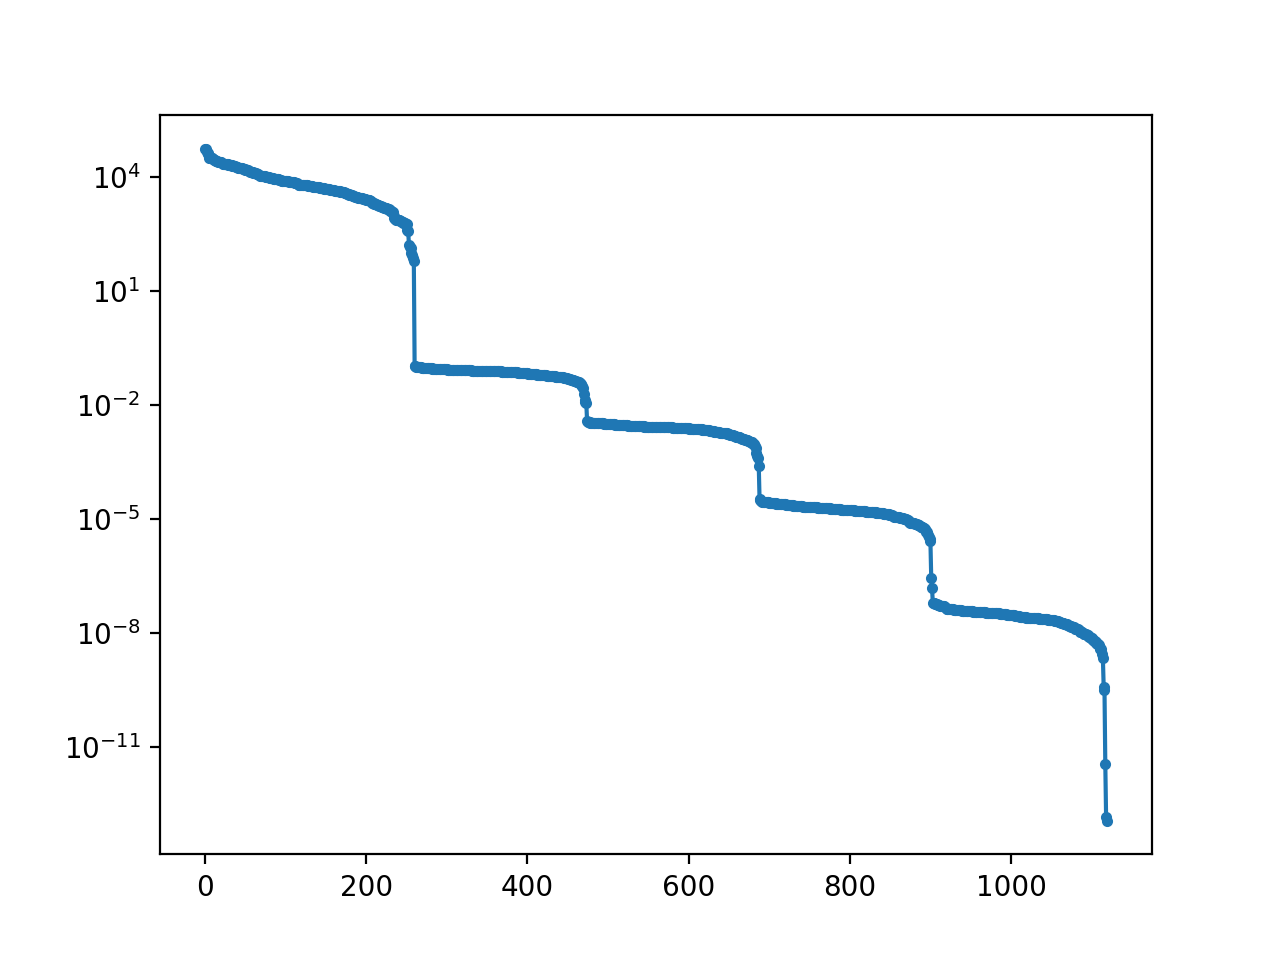

In [147]:
def SortedEigensystem(matrix):
    """Returns the eigensystem of the input matrix where eigenvalues and eigenvectors are sorted by descending absolute value."""
    evals,evecs = np.linalg.eig(matrix)
    indices = np.argsort(np.abs(evals))[::-1]   
    return evals[indices], evecs[:,indices]    

A = lps.ls.get_A()[:,:,0]
AtA = A.T.conj().dot(A)
evals, evecs = SortedEigensystem(AtA)
plt.figure()
plt.semilogy(np.abs(evals),'.-')

In [143]:
print meta

{'conv_crit': 1.0996943327397976e-08, 'chisq': 1.3795747379688071e-11, 'iter': 200}


1.37957473797e-11


<IPython.core.display.Javascript object>


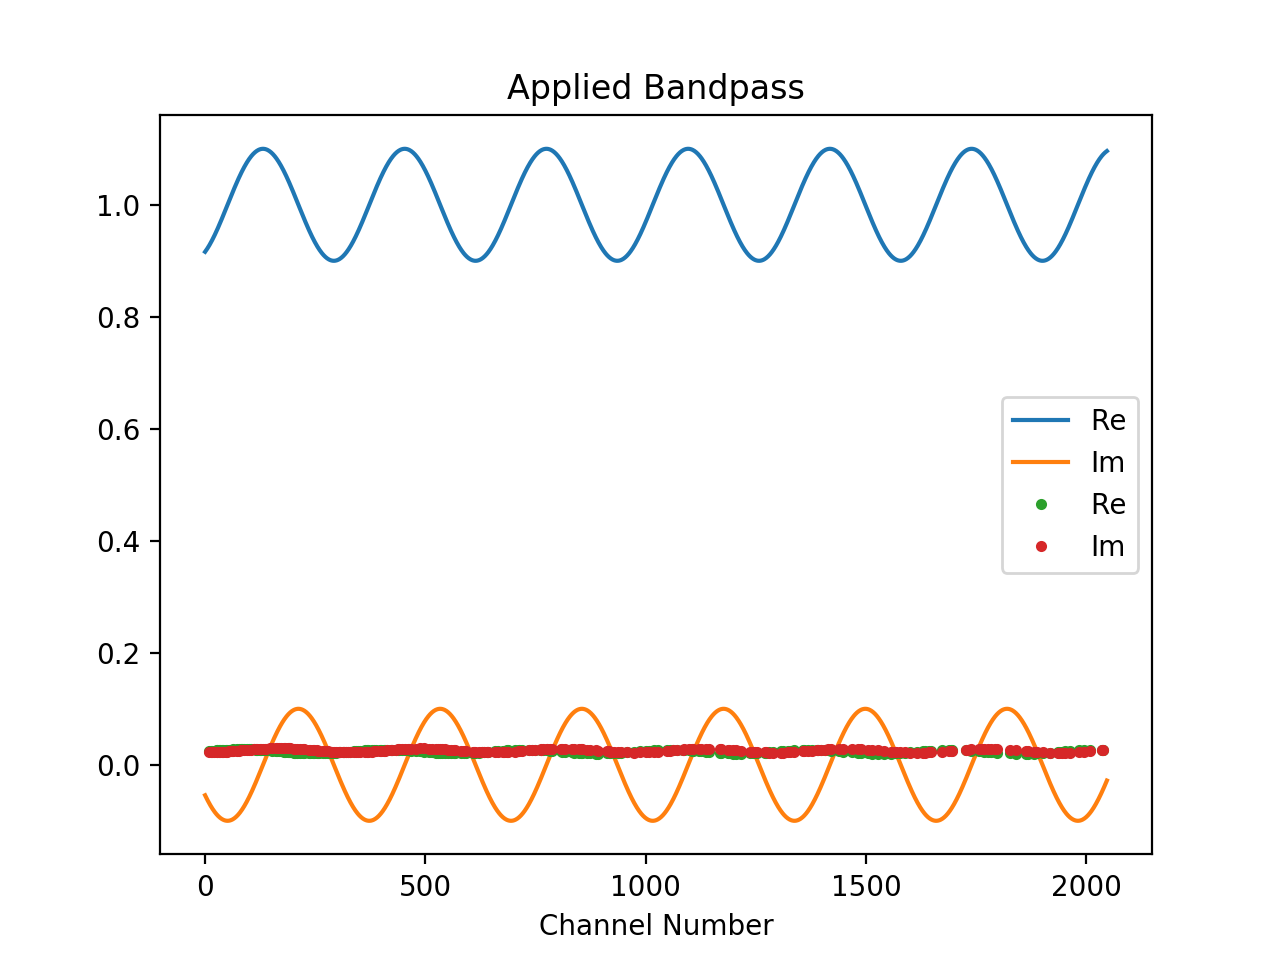

In [148]:
print meta['chisq']
bp_est = uc.bandpass(sol1)

plt.figure()
plt.title('Applied Bandpass')
plt.plot(bandpass.keys(), np.real(bandpass.values()), label='Re')
plt.plot(bandpass.keys(), np.imag(bandpass.values()), label='Im')

plt.plot(bp_est.keys(), np.real(bp_est.values()), '.', label='Re')
plt.plot(bp_est.keys(), np.imag(bp_est.values()), '.', label='Im')
plt.legend()
plt.xlabel('Channel Number');

<IPython.core.display.Javascript object>


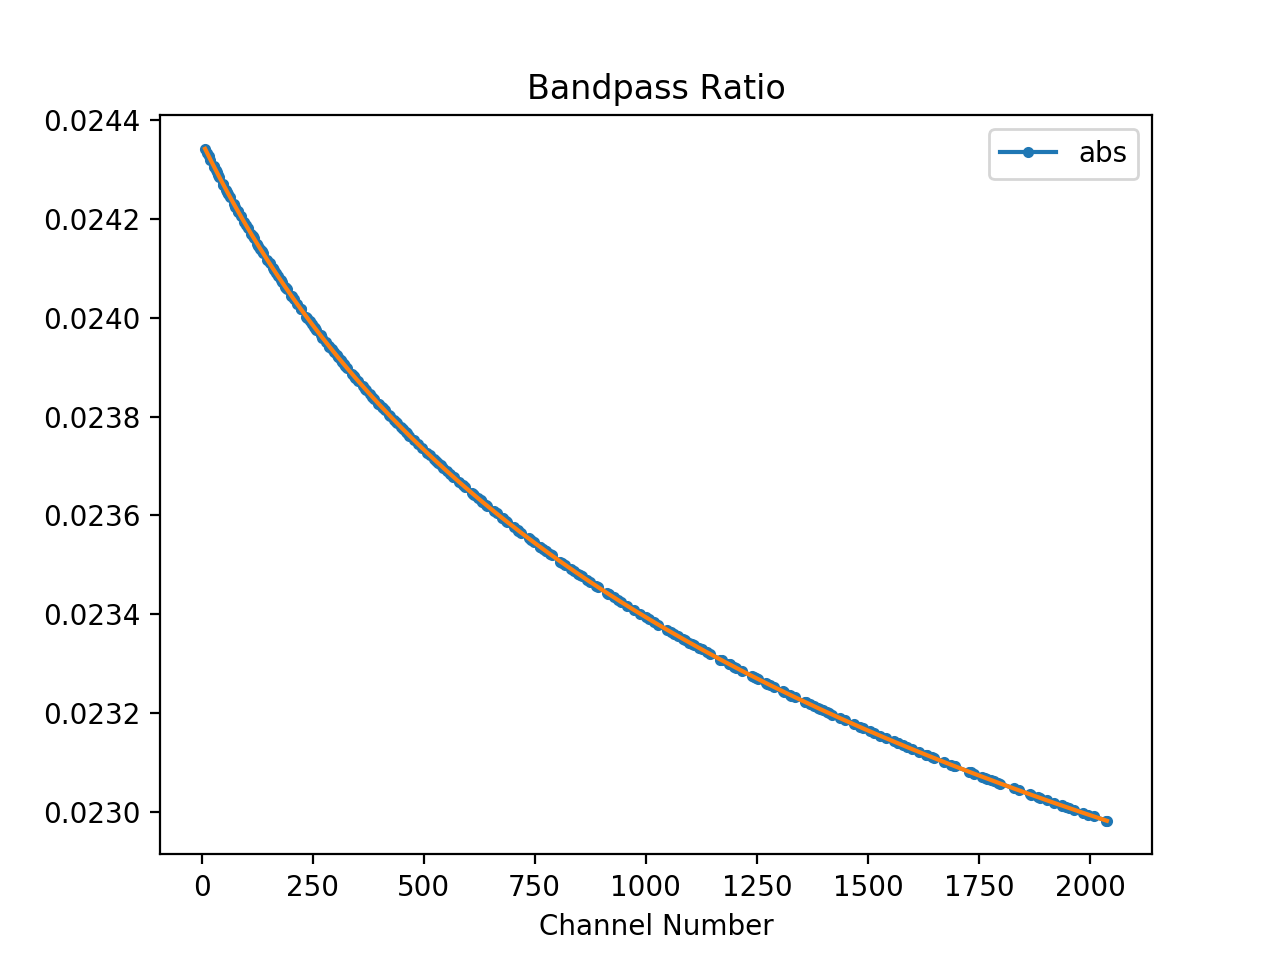

In [145]:
plt.figure()
plt.title('Bandpass Ratio')

bp_chans = sorted(bp_est.keys())
bp_ratio = [bp_est[chan] / bandpass[chan] for chan in bp_chans]
plt.plot(bp_chans, bp_ratio, '.-', label='abs')
#plt.plot(bp_chans, np.angle(bp_ratio), '.-', label='angle')
plt.legend()
plt.xlabel('Channel Number');

bp_freqs = [chans[bp_chan] for bp_chan in bp_chans]
fit = np.polyfit(np.log10(bp_freqs), bp_ratio, 8)

bp_correction = np.polyval(fit, np.log10(bp_freqs))

#plt.figure()
plt.plot(bp_chans, bp_correction)

final_bp = np.array([bp_est[chan] for chan in bp_chans])
final_bp /= bp_correction
true_bp = [bandpass[chan] for chan in bp_chans]


1.37488058662e-07


<IPython.core.display.Javascript object>


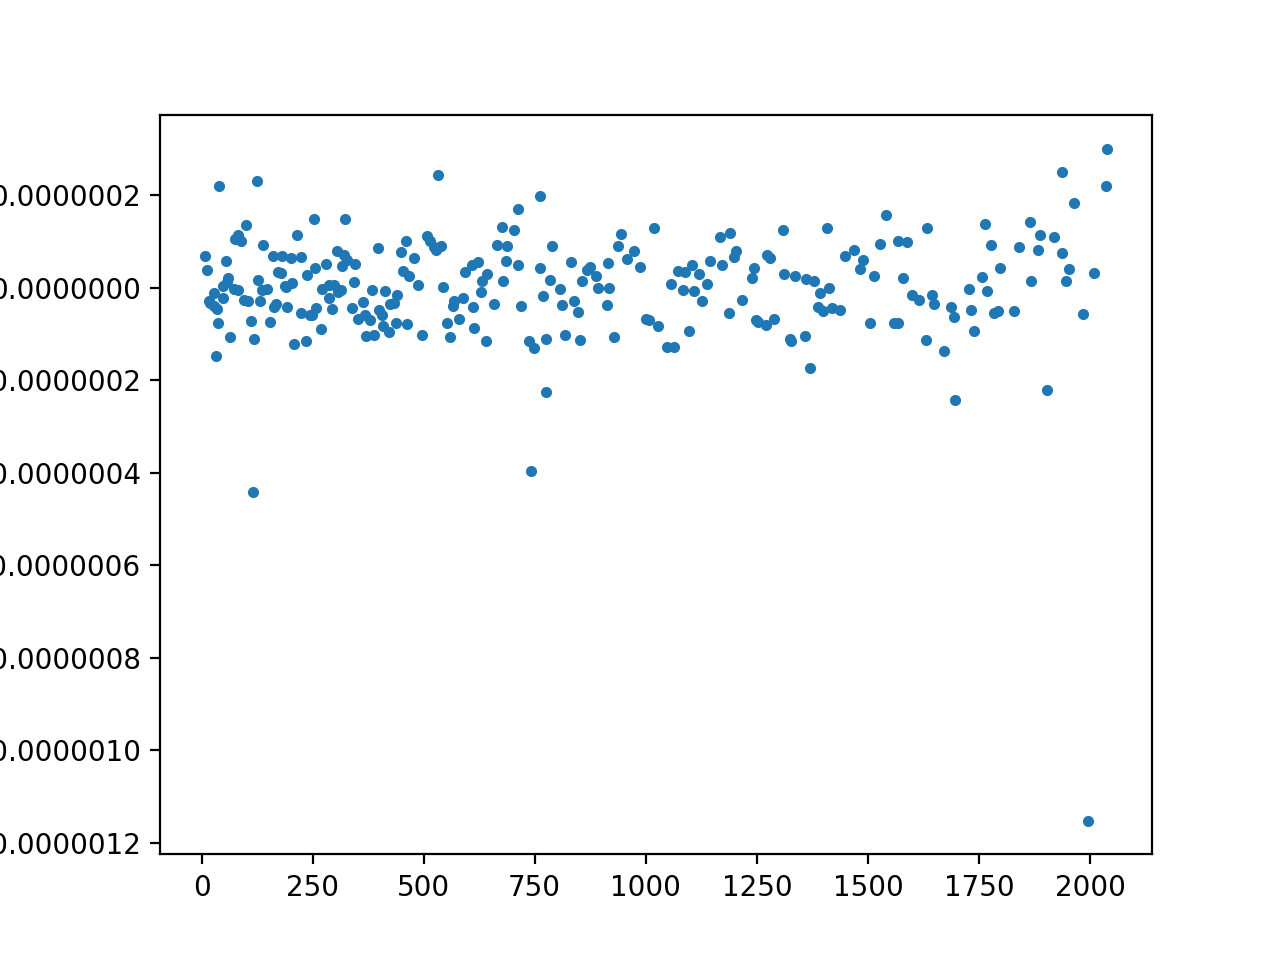

In [150]:
print np.linalg.norm(true_bp - final_bp) / np.linalg.norm(true_bp)
plt.figure()
plt.plot(bp_chans, final_bp - true_bp,'.')